https://hipster4020.tistory.com/79

https://github.com/cyang-kth/maximum-coverage-location

https://colab.research.google.com/github/Gurobi/modeling-examples/blob/master/facility_location/facility_location_gcl.ipynb#scrollTo=mKg4EQZ-_Z2R

solve a facility location optimization model python

In [ ]:
! pip install geopandas

In [ ]:
! pip install gurobipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.5 MB 4.8 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas

In [ ]:
# fdshop_raw = pd.read_csv('refined/food_raw.csv',sep=',',encoding = 'utf-8-sig')
fdshop = pd.read_excel('/content/drive/Shareddrives/데마 팀플 2/텀프로젝트/SIG_20220324/용인시경로당2.xlsx')
fdshop

,연번,읍면동,경로당 명칭,소 재 지,Latitude,Longitude,층수,회원수,난방방식,연 락 처,등 록 일,시설면적(㎡)
0,1.0,포곡읍,삼계1리경로당,경기도 용인시 처인구 포곡읍 포곡로297번길10-5,37.281620,127.231881,1.0,42.0,도시가스,031-332-5238,1/1/1983,66.00
1,2.0,포곡읍,삼계2리경로당,경기도 용인시 처인구 포곡읍 백옥대로1910번길 9,37.296687,127.234598,1.0,48.0,도시가스,031-322-6459,1/1/1978,99.00
2,3.0,포곡읍,삼계3리경로당,경기도 용인시 처인구 포곡읍 백옥대로1800번길47-8,37.287358,127.238736,1.0,26.0,도시가스,031-332-7857,10/14/2004,68.40
3,4.0,포곡읍,삼계4리경로당,경기도 용인시 처인구 포곡읍 두계로20번길 8,37.279430,127.233689,1.0,50.0,도시가스,031-334-4109,3/31/2004,131.00
4,5.0,포곡읍,삼계5리경로당,경기도 용인시 처인구 포곡읍 백옥대로1800번길 22,37.286968,127.236662,1.0,25.0,심야전기,031-321-4116,2/12/2004,99.00
...,...,...,...,...,...,...,...,...,...,...,...,...
299,378.0,동부동,해곡리경로당 (용인시),경기도 용인시 처인구 동부로 743(해곡동),37.188279,127.269469,1.0,34.0,심야보일러,031-339-4289,1/1/2002,119.71
300,379.0,동부동,호동경로당 (호동새마을회),경기도 용인시 처인구 호동로32번길 2(호동),37.207046,127.234283,1.0,28.0,심야보일러,031-321-3481,1/1/1998,90.60
301,380.0,동부동,예직경로당 (호2통새마을회),경기도 용인시 처인구 예직로37(호동),37.189103,127.258616,1.0,25.0,심야보일러,031-333-3775,1/1/1997,96.30
302,381.0,동부동,호3통 경로당 (호3통새마을회),경기도 용인시 처인구 해실로46번길 61-5(호동),37.178903,127.270821,1.0,21.0,심야보일러,031-323-1809,2/11/2011,48.75


In [ ]:
fdshop_arr = fdshop[['읍면동','경로당 명칭','소 재 지','Longitude','Latitude']]
fdshop_arr.columns = ['읍면동','경로당 명칭','소 재 지','x', 'y']

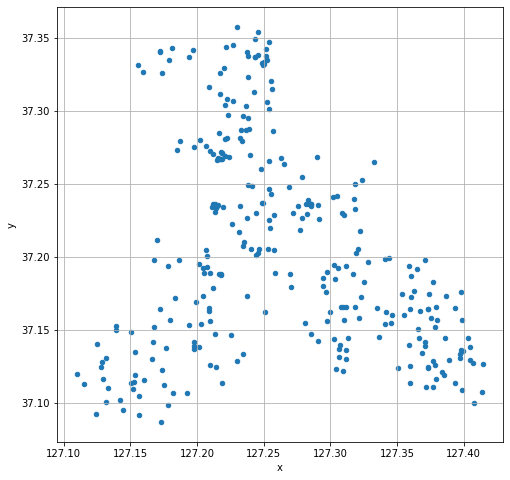

In [ ]:
yongin_client = fdshop_arr.plot.scatter(x='x', y='y', figsize=(8, 8), grid = True)

In [ ]:
import numpy as np
from scipy.spatial import distance_matrix
from gurobipy import *
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point
from numpy import random

def generate_candidate_sites(points,M=100):
    '''
    Generate M candidate sites with the convex hull of a point set
    Input:
        points: a Numpy array with shape of (N,2)
        M: the number of candidate sites to generate
    Return:
        sites: a Numpy array with shape of (M,2)
    '''
    hull = ConvexHull(points)
    polygon_points = points[hull.vertices]
    poly = Polygon(polygon_points)
    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    while len(sites) < M:
        random_point = Point([random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            sites.append(random_point)
    return np.array([(p.x,p.y) for p in sites])

    """
    Solve maximum covering location problem
    Input:
        points: input points, Numpy array in shape of [N,2]
        K: the number of sites to select
        radius: the radius of circle
        M: the number of candidate sites, which will randomly generated inside
        the ConvexHull wrapped by the polygon
    Return:
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        f: the optimal value of the objective function
    """
def mclp(points,K,radius,M):
    print('----- Configurations -----')
    print('  Number of points %g' % points.shape[0])
    print('  K %g' % K)
    print('  Radius %g' % radius)
    print('  M %g' % M)
    import time
    start = time.time()
    sites = generate_candidate_sites(points,M)
    J = sites.shape[0]
    I = points.shape[0]
    D = distance_matrix(points,sites)
    mask1 = D<=radius
    D[mask1]=1
    D[~mask1]=0
    # Build model
    m = Model()
    # Add variables
    x = {}
    y = {}
    for i in range(I):
      y[i] = m.addVar(vtype=GRB.BINARY, name="y%d" % i)
    for j in range(J):
      x[j] = m.addVar(vtype=GRB.BINARY, name="x%d" % j)

    m.update()
    # Add constraints
    m.addConstr(quicksum(x[j] for j in range(J)) == K)

    for i in range(I):
        m.addConstr(quicksum(x[j] for j in np.where(D[i]==1)[0]) >= y[i])

    m.setObjective(quicksum(y[i]for i in range(I)),GRB.MAXIMIZE)
    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('  Optimal coverage points: %g' % m.objVal)
    
    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            # print v.varName,v.x
            if v.x==1 and v.varName[0]=="x":
               solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites,m.objVal

def plot_input(points):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

def plot_result(points,opt_sites,radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    plt.scatter(opt_sites[:,0],opt_sites[:,1],c='C1',marker='+')
    for site in opt_sites:
        circle = plt.Circle(site, radius, color='C1',fill=False,lw=2)
        ax.add_artist(circle)
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)
    return opt_sites[:,0],opt_sites[:,1]

In [ ]:
import numpy as np
Npoints = 300
# Generate points in uniform distribution 
# points = np.random.rand(Npoints,2)

# Generate points in moon distribution
from sklearn.datasets import make_moons
points,_ = make_moons(Npoints,noise=0.15)

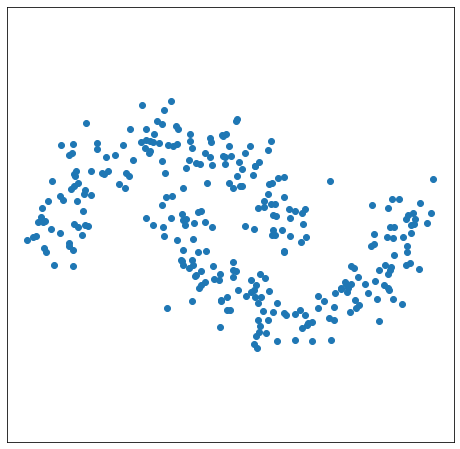

In [ ]:
# Plot input data
plot_input(points)

In [ ]:
points

In [ ]:
yongin_client

In [ ]:
xx=fdshop['Latitude'].values
xx[0:5]

array([37.2816196, 37.2966873, 37.2873579, 37.27943  , 37.2869679])

In [ ]:
xx.shape

(304,)

In [ ]:
yy=fdshop['Longitude'].values
yy [0:5]

array([127.2318807, 127.2345981, 127.2387356, 127.2336892, 127.2366622])

In [ ]:
target_list=[]
for i in range(304):
  c=[xx[i],yy[i]]
  target_list.append(c)

target_list[0:5]
  

[[37.2816196, 127.2318807],
 [37.2966873, 127.2345981],
 [37.2873579, 127.2387356],
 [37.27943, 127.2336892],
 [37.2869679, 127.2366622]]

In [ ]:
import numpy as np

In [ ]:
target_array=np.array(target_list)
target_array

----- Configurations -----
  Number of points 304
  K 4
  Radius 0.07
  M 100
----- Output -----
  Running time : 0.07447457313537598 seconds
  Optimal coverage points: 295


(array([37.15403125, 37.22756145, 37.15342317, 37.32437679]),
 array([127.15948313, 127.27481401, 127.36882889, 127.20433219]))

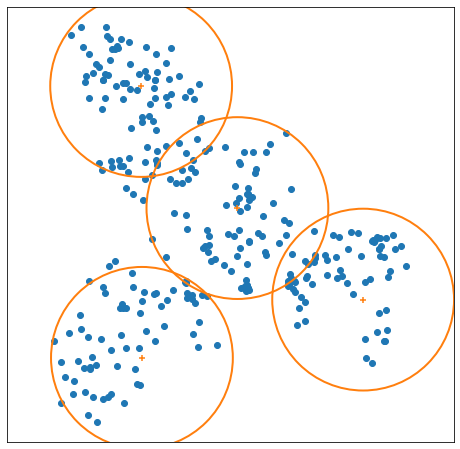

In [ ]:
# Number of sites to select
K = 4

# Service radius of each site
radius = 0.07

# Candidate site size (random sites generated)
M = 100

# Run mclp opt_sites is the location of optimal sites and f is the points covered
opt_sites,f = mclp(target_array,K,radius,M)

# Plot the result
plot_result(target_array,opt_sites,radius)